In [1]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
import os

from scipy.io import loadmat
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from encoder_LPV_models import LPV_multi_encoder, LPV_single_encoder

C:\Users\s143190\Anaconda3\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [2]:
#Remove exp_p
#3 Cases with 
# * Single use encoder
# * Multi measured encoder -> simulation with model output
# * Multi model    encoder -> simulation with model output
# - SS_encoder
# Sent data and bit of a figure.
# csv .mat
def loadsets(names, include_p=False):
    lis = []
    for n in names:
        out = loadmat(n)
        print(n)
        print(out.keys(),out['u_i2'].shape)
        u = np.concatenate([out['u_i2'],out['u_q1d'] if include_p else out['u_q1dref']],axis=1)
        y = out['y_q4d'][:,0]
        lis.append(deepSI.System_data(u=u,y=y))
    return deepSI.System_data_list(lis), out

m = './data/'

train_names = [m+i for i in os.listdir(m) if 'estim.' in i]
val_names = [m+i for i in os.listdir(m) if 'valid.' in i]

train, out = loadsets(train_names,include_p=True)
test, out = loadsets(val_names,include_p=True)
test = test[0]

# sys = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10))
# sys.init_model(train)
# sys.apply_experiment(test[0][:1000])
# sys.filter_experiment(test[0][:1000])
# sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)


./cdc2022-dllpvid-main/software/data/ML_estim.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (10000, 1)
./cdc2022-dllpvid-main/software/data/ML_valid.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (30000, 1)


In [3]:
sys_multi = deepSI.load_system('./models/LPV_multi-nx-5-Np-3-long-nf-60-include_u_in_p')
sys_single = deepSI.load_system('./models/LPV_single-nx-5-Np-3-nf-60-include_u_in_p')


In [ ]:
sys_multi

In [4]:
test_multi_p_filt = sys_multi.apply_experiment(test,filt=True)
test_multi_p_sim = sys_multi.apply_experiment(test,filt=False)
test_single_p_sim = sys_single.apply_experiment(test)



test_multi_p_filt= 0.023591833557044594
test_multi_p_sim= 0.03788430453531621
test_single_p_sim= 0.03098238997607286


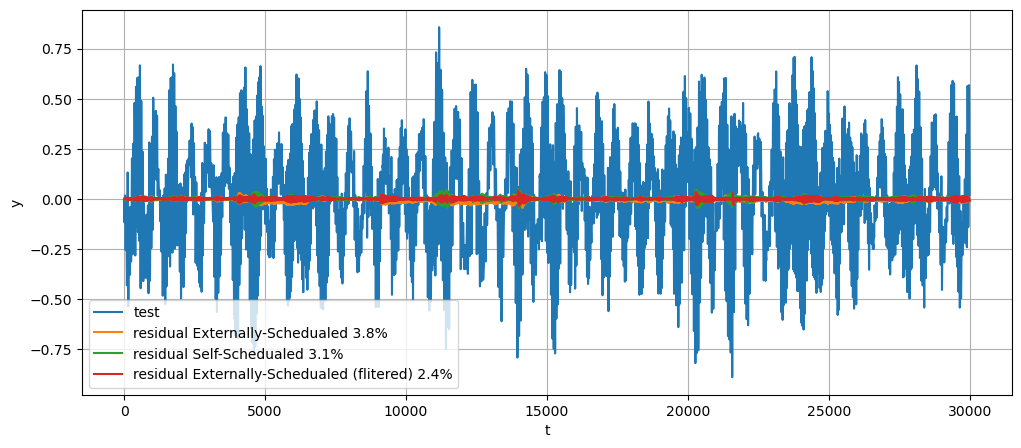

In [5]:
#u included
test_multi_p_filt_NRMS = test_multi_p_filt.NRMS(test)
print('test_multi_p_filt=',test_multi_p_filt_NRMS)
test_multi_p_sim_NRMS = test_multi_p_sim.NRMS(test)
print('test_multi_p_sim=',test_multi_p_sim_NRMS)
test_single_p_sim_NRMS = test_single_p_sim.NRMS(test)
print('test_single_p_sim=',test_single_p_sim_NRMS)

plt.figure(figsize=(12,5))
test.plot()
(test-test_multi_p_sim).plot()
(test-test_single_p_sim).plot()
(test-test_multi_p_filt).plot()

plt.legend(['test',f'residual Externally-Schedualed {test_multi_p_sim_NRMS:.1%}',\
            f'residual Self-Schedualed {test_single_p_sim_NRMS:.1%}', \
            f'residual Externally-Schedualed (flitered) {test_multi_p_filt_NRMS:.1%}'])
plt.grid()
plt.show()

In [38]:
BFR_LPV_OE = 89.96
BRF_LPV_PEM_SS = 90.40
BFR_to_NRMS = lambda BFR: (1-BFR/100)
NRMS_to_BFR = lambda NRMS: (1-NRMS)*100

NRMS_LPV_OE = BFR_to_NRMS(BFR_LPV_OE)
NRMS_LPV_PEM_SS = BFR_to_NRMS(BRF_LPV_PEM_SS)
NRMS_self_schedualed = test_single_p_sim_NRMS
BFR_self_schedualed = NRMS_to_BFR(NRMS_self_schedualed)

print('NRMS_LPV_OE',f'{NRMS_LPV_OE:.1%}')
print('NRMS_LPV_PEM_SS',f'{NRMS_LPV_PEM_SS:.1%}')
print('NRMS_self_schedualed',f'{NRMS_self_schedualed:.1%}')

print('BFR_self_schedualed',f'{BFR_self_schedualed}%')

NRMS_LPV_OE 10.0%
NRMS_LPV_PEM_SS 9.6%
NRMS_self_schedualed 3.1%
BFR_self_schedualed 96.90176100239272%


In [37]:
1-NRMS_self_schedualed

0.9690176100239272

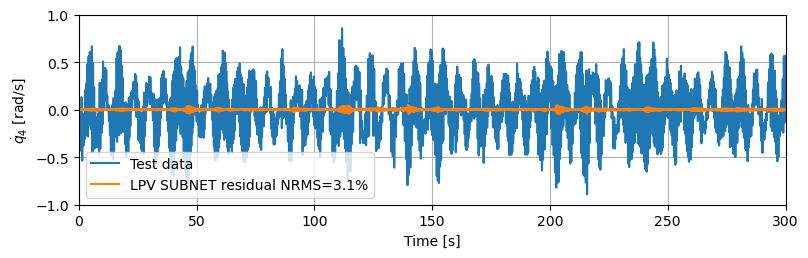

In [30]:
Ts = 1/100
plt.figure(figsize=(8,2.5))
plt.plot(np.arange(len(test.y))*Ts, test.y,label='Test data')
plt.plot(np.arange(len(test.y))*Ts, test.y-test_single_p_sim.y,label=f'LPV SUBNET residual NRMS={NRMS_self_schedualed:.1%}')
plt.xlim(0,300)
plt.legend()
plt.ylabel('$\\dot{q}_4$ [rad/s]')
plt.xlabel('Time [s]')
plt.grid()
plt.ylim(-1,1)
plt.tight_layout(pad=0.4)
plt.savefig('../../../figures/LPV-SUBNET-gyro-results.jpg',dpi=250)
# plt.savefig('../../../figures/LPV-SUBNET-gyro-results.pdf')
plt.show()


In [6]:
from scipy.io import savemat
d = {'u_test':test.u,'y_test':test.y,\
     'test_single_p_sim':test_single_p_sim.y[:,None], \
     'test_multi_p_filt':test_multi_p_filt.y[:,None],\
     'test_multi_p_sim':test_multi_p_sim.y[:,None]}
savemat('single-and-multi-LPV-test-results-u-included-in-p.mat',d)




In [28]:
loadmat('single-and-multi-LPV-test-results.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue Mar 15 09:28:05 2022',
 '__version__': '1.0',
 '__globals__': [],
 'u_test': array([[ 0.06170841, 40.        ],
        [ 0.62879373, 39.99205248],
        [ 0.54593754, 39.9705122 ],
        ...,
        [-0.68727306, 37.22219131],
        [-0.39329317, 37.22349167],
        [-0.08935858, 37.22465611]]),
 'y_test': array([[ 0.        , -0.00112241, -0.00686144, ...,  0.03839013,
          0.0276955 ,  0.01983393]]),
 'test_single_p_sim': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04215459],
        [ 0.03190592],
        [ 0.02446045]]),
 'test_multi_p_filt': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04833194],
        [ 0.03864255],
        [ 0.03155755]]),
 'test_multi_p_sim': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04985925],
        [ 0.03998259],
        [ 0.0327